В качестве домашней работы вам необходимо будет реализовать и сравнить методы:
<b>Momentum, AdaDelta, Adam</b>.

Также вам будет предложено сравнить реализованные методы при обучении полносвязной и сверточной нейронных сетей на датасете MNIST.



In [1]:
from functools import partial

import numpy as np
import torch
from tqdm.auto import tqdm
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from IPython.display import HTML
%matplotlib inline
plt.rc('animation', html='html5')

In [2]:
# https://github.com/dzlab/deepprojects/blob/master/visualization/Optimizers_in_Action.ipynb

def grid_samples(center=[0, 0], offset=5, size=100):
    range1 = np.linspace(center[0]-offset, center[0]+offset, size)
    range2 = np.linspace(center[1]-offset, center[1]+offset, size)
    return torch.from_numpy(np.stack(np.meshgrid(range1, range2))).float()


def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1)


def msre(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1).sqrt()


def mae(y, y_hat):
    return ((y - y_hat).abs()).mean(axis=-1)


class LossAnimator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = len(X)

    def loss_func(self, W, loss):
        shape = W.shape
        return loss((self.X @ W.view(shape[0], -1)).T, self.y).view(shape[1:])

    def plot_loss_funcs(self, weights, fcts, titles, view=(20, 50)):
        num_fcts = len(fcts)
        fig = plt.figure(figsize=(7 * num_fcts,7))
        for i in range(num_fcts):
            loss = self.loss_func(weights, loss=fcts[i])
            ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
            ax.plot_surface(*weights, loss, cmap='viridis')
            ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
            ax.set_title(titles[i])
            ax.view_init(*view)

    def _init_animation(self, epochs, train_data):
        self.train_data = train_data
        self.epochs = epochs
        self.nmethods = len(train_data)

        weights = grid_samples(offset=5)

        max_loss = max([data['losses'].max() for data in train_data.values()])
        loss_curve = self.loss_func(weights, loss=mse)
        colors = cm.rainbow(np.linspace(0, 1, self.nmethods))


        self.fig = plt.figure(figsize=(14, 8))
        self.gs = GridSpec(2, 2, width_ratios=[1, 2.5])

        self.ax0 = self.fig.add_subplot(self.gs[0,0])
        self.lines0 = {
            name: self.ax0.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax0.scatter(self.X[:,0], self.y, c='orange', label='Ground truth')
        self.ax0.set_ylim(self.y.min(), self.y.max())
        self.ax0.set_title('Ground truth & Model', fontsize=16)
        self.ax0.legend(loc='lower right')

        self.ax1 = self.fig.add_subplot(self.gs[:,1], projection='3d')
        self.ax1.plot_surface(*weights, loss_curve-0.5, cmap='viridis', alpha=0.8)
        self.ax1.view_init(50, 70)
        self.lines1 = {
            name: self.ax1.plot3D([], [], [], c=c, marker='o', alpha=0.9, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax1.set_title('Loss', fontsize=16, pad=20)
        self.ax1.set_xlabel('w0')
        self.ax1.set_ylabel('w1')
        self.ax1.set_zlabel('Loss')
        self.ax1.legend()

        self.ax2 = self.fig.add_subplot(self.gs[1,0])
        self.lines2 = {
            name: self.ax2.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax2.set_title('Loss', fontsize=16)
        self.ax2.set_ylabel('loss')
        self.ax2.set_ybound(0, max_loss)
        self.ax2.set_xlim(0, epochs)
        self.ax2.legend(loc='center right')

        self.fig.tight_layout()
        self.fig.subplots_adjust(top=0.85)

        plt.close()

        return self.fig

    def _animate(self, i):
        steps = np.arange(i+1)
        left = max(0, i-20)
        for name, data in self.train_data.items():
            # plot ground truth & model
            self.lines0[name].set_data(self.X[:, 0], self.X @ data['weights'][i])

            # plot loss (output of the sampling)
            self.lines1[name].set_data(data['weights'][left:i+1, 0], data['weights'][left:i+1, 1])
            self.lines1[name].set_3d_properties(data['losses'][left:i+1])

            self.lines2[name].set_data(steps, data['losses'][:i+1])

        self.fig.suptitle(f'Epoch: {i}/{self.epochs}', fontsize=22)

    def animate(self, epochs, train_data, step_skip=1):
        self._init_animation(epochs, train_data)
        anim = animation.FuncAnimation(self.fig, self._animate, frames=range(0, epochs, step_skip), interval=100 * step_skip)
        return HTML(anim.to_html5_video())

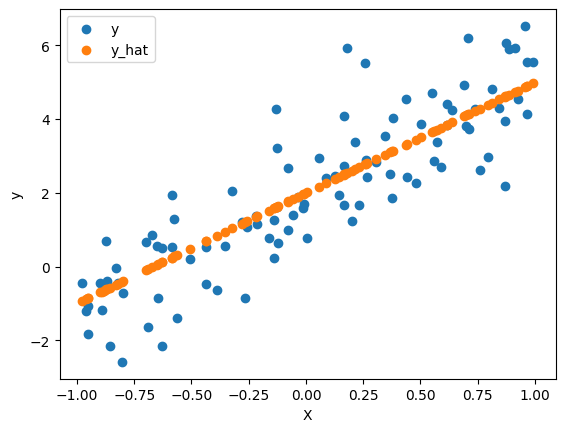

In [3]:
size = 100
X = torch.ones(size, 2)
X[:, 0].uniform_(-1., 1)

y_hat = 3 * X[:, 0] + 2
y = y_hat + torch.randn(size)

loss_animator = LossAnimator(X, y)

plt.scatter(loss_animator.X[:,0], loss_animator.y, label='y');
plt.scatter(loss_animator.X[:,0], y_hat, label='y_hat');
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

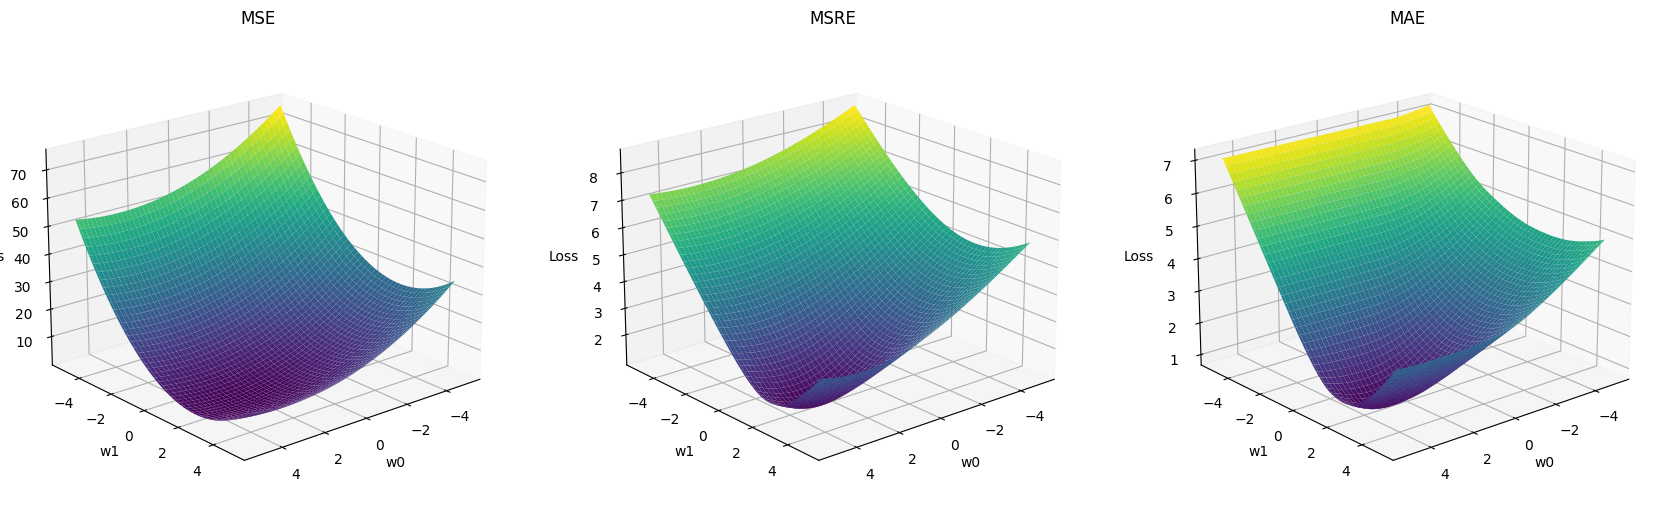

In [6]:
weights = grid_samples()
loss_animator.plot_loss_funcs(weights, [mse, msre, mae], ['MSE', 'MSRE', 'MAE'])

In [3]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def pre_step(self):
        pass

    def step(self):
        pass

    def update_param(self, p):
        raise NotImplementedError()


In [4]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths)
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses


In [5]:
def compare_optimizers(
    loss_animator,
    fn,
    optim_list,
    start_point,
    num_iter = 50,
    step_skip = 1
):
    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)
    for name, optim, args in optim_list:
        points, losses = optimize_function(loss_func, optim, args, start_point, num_iter)
        data[name] = {
            'weights': points,
            'losses': losses,
        }

    return loss_animator.animate(num_iter, data, step_skip=step_skip)

## **Реализация методов оптимизации**

### SGD
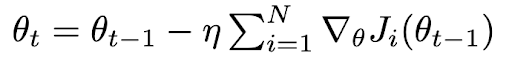

In [6]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for param in self.params:
                if param.grad is not None:
                    param -= self.lr * param.grad


### Nesterov accelerated gradient
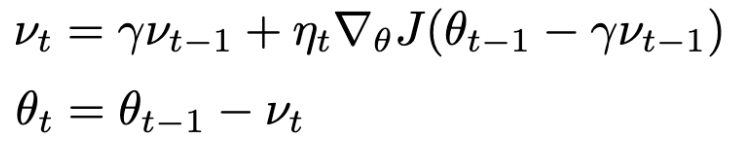

In [7]:
class NAG(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma
        self.momentum = [torch.zeros(param.shape) for param in self.params]

    def step(self):
        with torch.no_grad():
            for i, param in enumerate(self.params):
                if param.grad is not None:
                    prev_momentum = self.momentum[i]
                    self.momentum[i] = self.gamma * prev_momentum + self.lr * param.grad
                    param -= (1 + self.gamma) * self.momentum[i] - self.gamma * prev_momentum

### AdaGrad
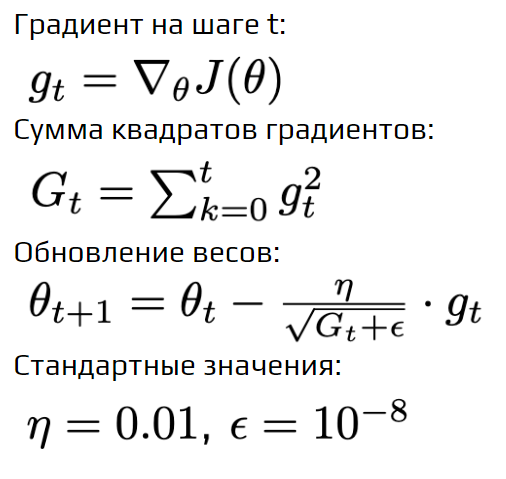

In [8]:
class AdaGrad(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2):
        super().__init__(params)

        self.eta = eta
        self.epsilon = epsilon
        self.G = [torch.zeros(param.shape) for param in self.params]

    def step(self):
        with torch.no_grad():
            for i, param in enumerate(self.params):
                if param.grad is not None:
                    self.G[i] += param.grad ** 2
                    param -= self.eta / torch.sqrt(self.G[i] + self.epsilon) * param.grad

### RMSProp

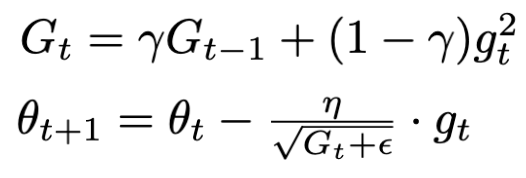

In [9]:
class RMSProp(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2, gamma=0.9):
        super().__init__(params)

        self.epsilon = epsilon
        self.eta = eta
        self.gamma = gamma
        self.G = [torch.zeros(param.shape) for param in self.params]

    def step(self):
        with torch.no_grad():
            for i, param in enumerate(self.params):
                if param.grad is not None:
                    self.G[i] = self.gamma * self.G[i] + (1 - self.gamma) * (param.grad ** 2)
                    param -= self.eta / torch.sqrt(self.G[i] + self.epsilon) * param.grad

### **SGD + Momentum**


In [10]:
class Momentum(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma
        self.momentum = [torch.zeros(param.shape) for param in self.params]

    def step(self):
        with torch.no_grad():
            for i, param in enumerate(self.params):
                if param.grad is not None:
                    self.momentum[i] = self.gamma * self.momentum[i] + self.lr * param.grad
                    param -= self.momentum[i]

### **AdaDelta**

In [11]:
class AdaDelta(Optimizer):
    def __init__(self, params, epsilon=1e-8, gamma=0.9):
        '''
        сходится долго, хотя интернет и документация pytorch говорят, что код верный
        '''
        super().__init__(params)

        self.epsilon = epsilon
        self.gamma = gamma

        self.G = [torch.zeros(param.shape) for param in self.params]
        self.theta = [torch.zeros(param.shape) for param in self.params]

    def step(self):
        with torch.no_grad():
            for i, param in enumerate(self.params):
                if param.grad is not None:
                    self.G[i] = self.gamma * self.G[i] + (1 - self.gamma) * (param.grad ** 2)
                    delta = (torch.sqrt(self.theta[i] + self.epsilon) / torch.sqrt(self.G[i] + self.epsilon)) * param.grad
                    self.theta[i] = self.gamma * self.theta[i] + (1 - self.gamma) * (delta ** 2)
                    param -= delta

### **Adam**

In [12]:
class Adam(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2, beta_1=0.9, beta_2=0.999):
        super().__init__(params)
        self.epsilon = epsilon
        self.eta = eta

        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.iter = 1

        self.G = [torch.zeros(param.shape) for param in self.params]
        self.m = [torch.zeros(param.shape) for param in self.params]

    def step(self):
        with torch.no_grad():
            for i, param in enumerate(self.params):
                if param.grad is not None:
                    self.m[i] = self.beta_1 * self.m[i] + (1 - self.beta_1) * param.grad
                    self.G[i] = self.beta_2 * self.G[i] + (1 - self.beta_2) * (param.grad**2)

                    m_hat = self.m[i] / (1 - self.beta_1**self.iter)
                    g_hat = self.G[i] / (1 - self.beta_2**self.iter)

                    param -= (self.eta / torch.sqrt(g_hat + self.epsilon)) * m_hat
        self.iter += 1

In [ ]:
from functools import partial

points, losses = optimize_function(partial(loss_animator.loss_func, loss=mse), AdaDelta, {'eta': 1e-8}, start_point=[-4, -4], num_iter=100)

In [34]:
compare_optimizers(
    loss_animator,
    mse,
    [
        ['SGD', SGD, {'lr': 1e-1}],
        ['SGDMomentum', Momentum, {'lr': 1e-1}],
        ['Nesterov', NAG, {'lr': 1e-1}],
        ['AdaGrad', AdaGrad, {'eta': 1}],
        ['RMSProp', RMSProp, {'eta': 1}],
        ['AdaDelta', AdaDelta, {'epsilon': 1e-2}],
        ['Adam', Adam, {'eta': 1}]
    ],
    start_point=[-4, -4],
    num_iter=50
)

## **Сравнение реализованных методов на датасете MNIST**

In [13]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [14]:
train_dataset = MNIST('.', train=True, download=True, transform=transforms.ToTensor())
test_dataset = MNIST('.', train=False, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 82871978.18it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 70427728.97it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 20963090.91it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7849414.41it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [26]:
input_size = 28 * 28
num_classes = 10
n_hidden_neurons = 100

class MnistFCnet(nn.Module):
    def __init__(self, n_hidden_neurons=n_hidden_neurons):
        super().__init__()
        self.fc1 = nn.Linear(input_size, n_hidden_neurons)
        self.ac1 = nn.Sigmoid()
        self.fc2 = nn.Linear(n_hidden_neurons, num_classes)

    def forward(self, x):
        x = x.reshape(-1, input_size)
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x


class MnistConvnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1 = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2 = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = torch.nn.Linear(in_features= 5*5*16, out_features=120)
        self.act3 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(in_features=120, out_features=84)
        self.act4 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(in_features=84, out_features=10)


    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        return x

In [20]:
def train(model, optimizer, n_epochs, train_loader, val_loader):
    model = model.to(device)

    # храним по эпохам
    train_accuracies, train_losses = [], []
    val_accuracies, val_losses = [], []

    for epoch in range(n_epochs):
        model.train()
        train_loss, train_accuracy = [], []

        for x_train, y_train in tqdm(train_loader):
            x_train = x_train.to(device)
            y_train = y_train.to(device)

            y_pred = model.forward(x_train)

            loss = F.cross_entropy(y_pred, y_train)

            train_loss.append(loss.item())
            train_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_train).cpu().numpy().tolist())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        train_accuracies.append(np.mean(train_accuracy))
        train_losses.append(np.mean(train_loss))

        # валидация
        model.eval()
        val_loss, val_accuracy = [], []
        with torch.no_grad():
            for x_val, y_val in tqdm(test_loader):
                x_val = x_val.to(device)
                y_val = y_val.to(device)

                y_pred = model.forward(x_val).to(device)

                loss = F.cross_entropy(y_pred, y_val)
                val_loss.append(loss.item())
                val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).cpu().numpy().tolist())

        val_accuracies.append(np.mean(val_accuracy))
        val_losses.append(np.mean(val_loss))

        print(f'Epoch: {epoch}, train loss: {np.mean(train_loss)}, accuracy: {np.mean(train_accuracy)}')
        print(f'Epoch: {epoch}, val loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}')

    return {'train_losses': train_losses, 'train_accuracies': train_accuracies,
            'val_losses': val_losses, 'val_accuracies': val_accuracies}

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
history = {}

for model_name, model in {'mnist_fc': MnistFCnet, 'mnist_conv': MnistConvnet}.items():
    for optim_name, (optim, args) in {
        'Momentum': (Momentum, {'lr': 1e-2, 'gamma': 0.9}),
        'AdaDelta': (AdaDelta, {'epsilon': 1e-8, 'gamma': 0.9}),
        'Adam': (Adam, {'epsilon': 1e-8, 'eta': 1e-2})}.items():

        model = model()
        optimizer = optim(model.parameters(), **args)

        result = train(model, optimizer, 10, train_loader, test_loader)
        history[model_name + '_' + optim_name] = result

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 0, train loss: 0.2389340811132143, accuracy: 0.9246333333333333
Epoch: 0, val loss: 0.11750559434097575, accuracy: 0.9648


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1, train loss: 0.13299249876337127, accuracy: 0.9642333333333334
Epoch: 1, val loss: 0.1117300340356625, accuracy: 0.9703


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2, train loss: 0.12915187394125388, accuracy: 0.9662
Epoch: 2, val loss: 0.09696541457790223, accuracy: 0.9718


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3, train loss: 0.1231661692082882, accuracy: 0.9681333333333333
Epoch: 3, val loss: 0.1575298273761849, accuracy: 0.9631


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4, train loss: 0.11487622053850598, accuracy: 0.9705333333333334
Epoch: 4, val loss: 0.1356815804404537, accuracy: 0.9605


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 5, train loss: 0.1159492615964613, accuracy: 0.9706166666666667
Epoch: 5, val loss: 0.0992783470568024, accuracy: 0.9757


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 6, train loss: 0.1157982147509077, accuracy: 0.9713
Epoch: 6, val loss: 0.11808591199352898, accuracy: 0.9694


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 7, train loss: 0.11177195922025324, accuracy: 0.9724166666666667
Epoch: 7, val loss: 0.09409346202251116, accuracy: 0.9745


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 8, train loss: 0.11483489208826796, accuracy: 0.9726
Epoch: 8, val loss: 0.09759387861504655, accuracy: 0.9771


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 9, train loss: 0.1147364392724509, accuracy: 0.9726
Epoch: 9, val loss: 0.10773715711747908, accuracy: 0.976


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 0, train loss: 0.2358207444285353, accuracy: 0.9293166666666667
Epoch: 0, val loss: 0.14202625672080027, accuracy: 0.9577


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1, train loss: 0.12669212210029362, accuracy: 0.9611833333333333
Epoch: 1, val loss: 0.11858837310813915, accuracy: 0.9645


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2, train loss: 0.10482972573464115, accuracy: 0.9671666666666666
Epoch: 2, val loss: 0.11555628717866556, accuracy: 0.9661


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3, train loss: 0.09303550702060262, accuracy: 0.9708333333333333
Epoch: 3, val loss: 0.12018629909603122, accuracy: 0.9654


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4, train loss: 0.08520035189293945, accuracy: 0.9725333333333334
Epoch: 4, val loss: 0.11697167678729735, accuracy: 0.9644


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 5, train loss: 0.0808433996379841, accuracy: 0.9743
Epoch: 5, val loss: 0.1336751557427634, accuracy: 0.9636


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 6, train loss: 0.07645073512438685, accuracy: 0.9750333333333333
Epoch: 6, val loss: 0.1363343602444247, accuracy: 0.9602


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 7, train loss: 0.07338601562730036, accuracy: 0.97705
Epoch: 7, val loss: 0.10560934690442628, accuracy: 0.9716


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 8, train loss: 0.06876674972281326, accuracy: 0.9773666666666667
Epoch: 8, val loss: 0.14457772652798603, accuracy: 0.9621


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 9, train loss: 0.0666579931312163, accuracy: 0.9783
Epoch: 9, val loss: 0.1259860772495714, accuracy: 0.9674


In [ ]:
history

In [41]:
history['mnist_fc_Momentum']

{'train_losses': [0.6649129901051521,
  0.30507693971792854,
  0.2596951848566532,
  0.2270325972944498,
  0.202066218812267,
  0.18142927594085534,
  0.16550836165150007,
  0.15157352073043584,
  0.14001748485416174,
  0.13006188303281863],
 'train_accuracies': [0.8204333333333333,
  0.91275,
  0.9250666666666667,
  0.9343833333333333,
  0.9423666666666667,
  0.9477833333333333,
  0.9526333333333333,
  0.95705,
  0.9593166666666667,
  0.963],
 'val_losses': [0.32008987982956744,
  0.265675278606649,
  0.23320683156446623,
  0.21238056031136085,
  0.1875327430671444,
  0.17327116475181695,
  0.15817166057329018,
  0.1488481018150719,
  0.13813233928019986,
  0.13191053047017476],
 'val_accuracies': [0.9097,
  0.9238,
  0.932,
  0.938,
  0.9458,
  0.9504,
  0.9535,
  0.9564,
  0.9595,
  0.961]}

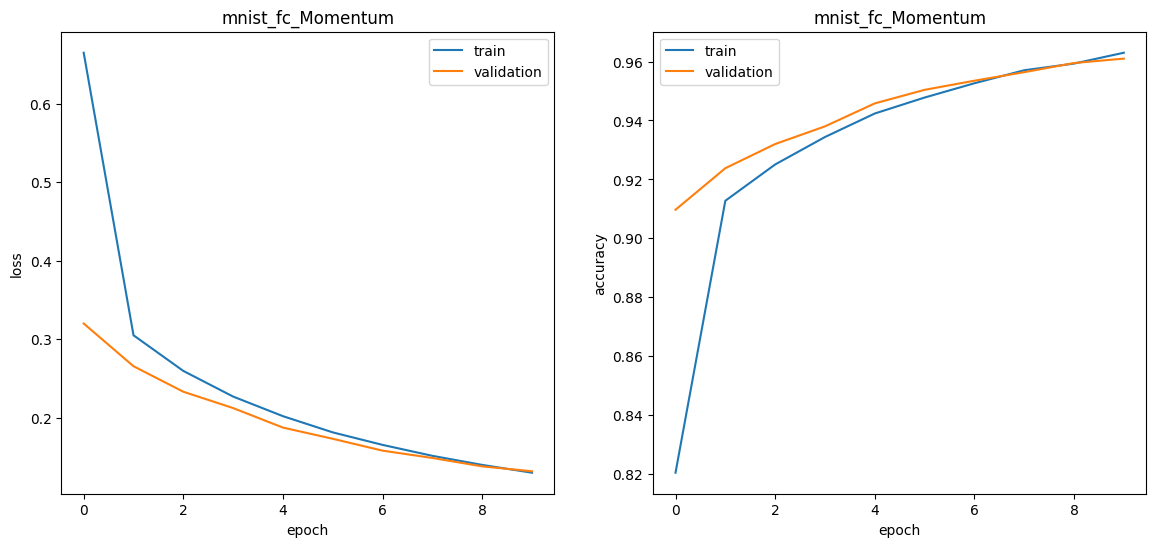

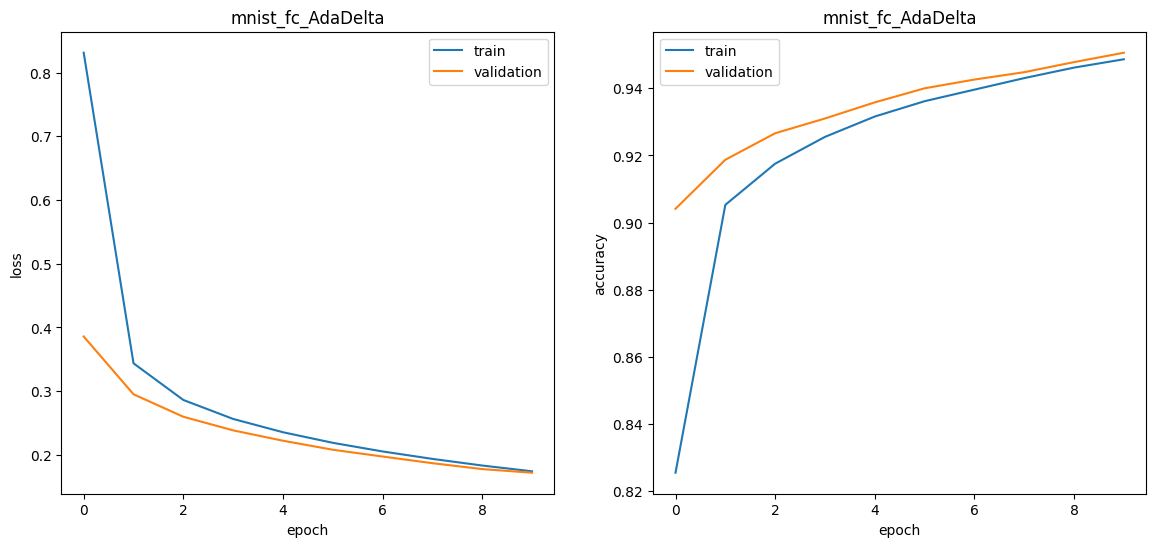

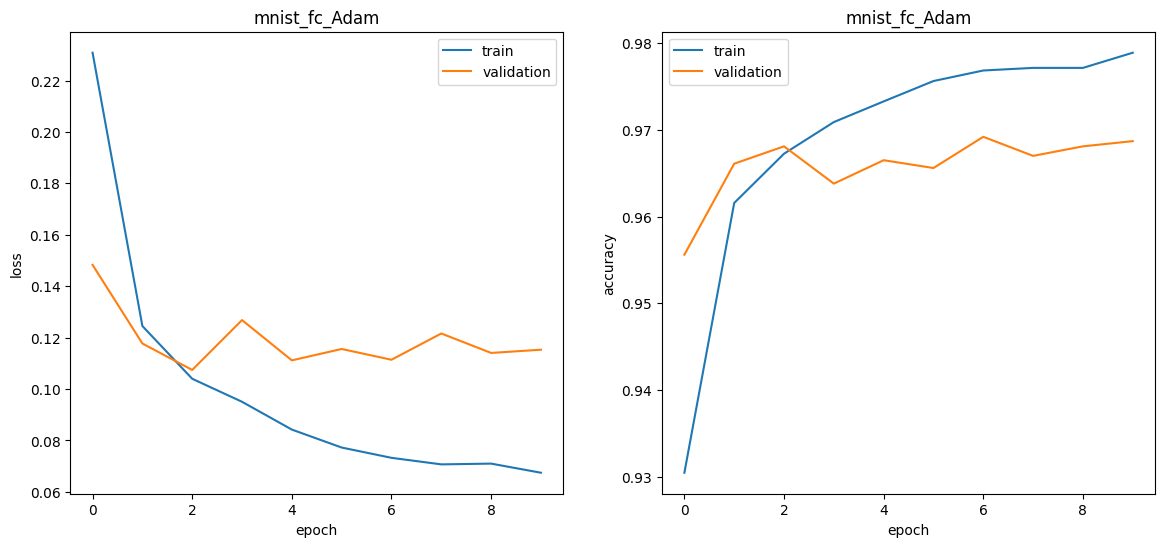

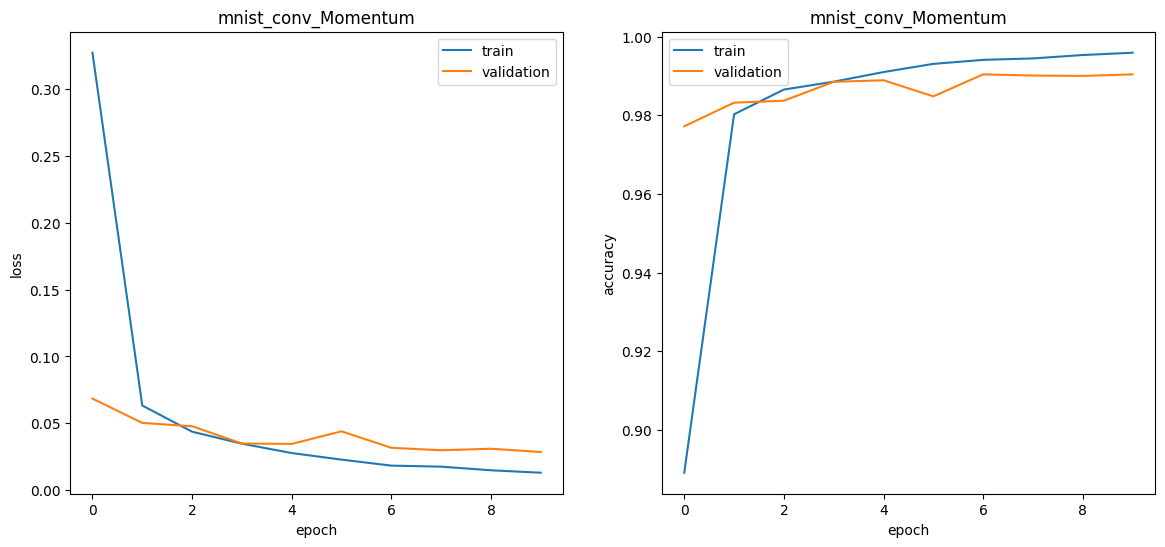

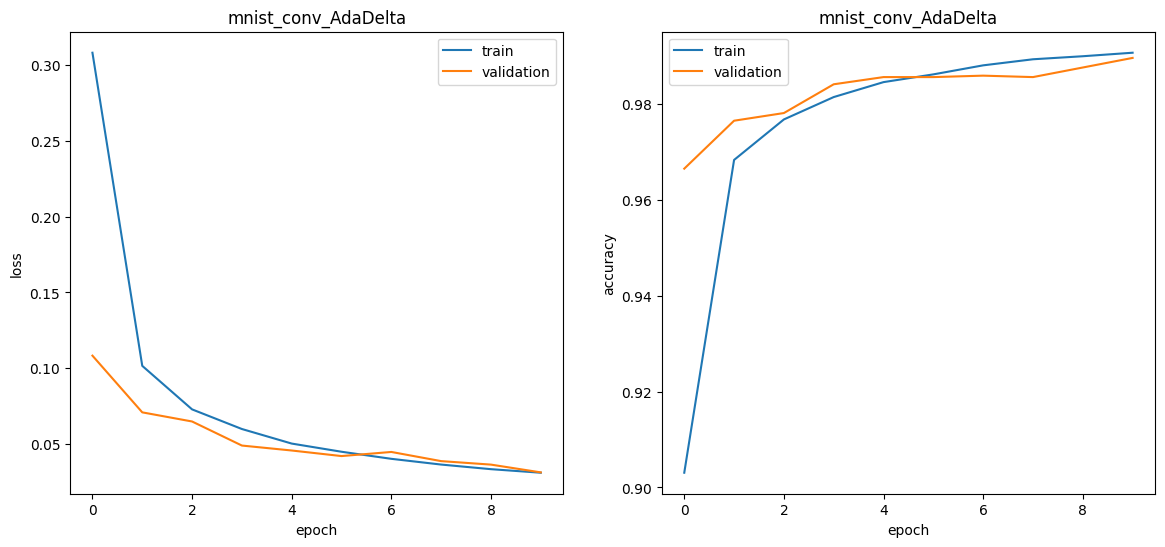

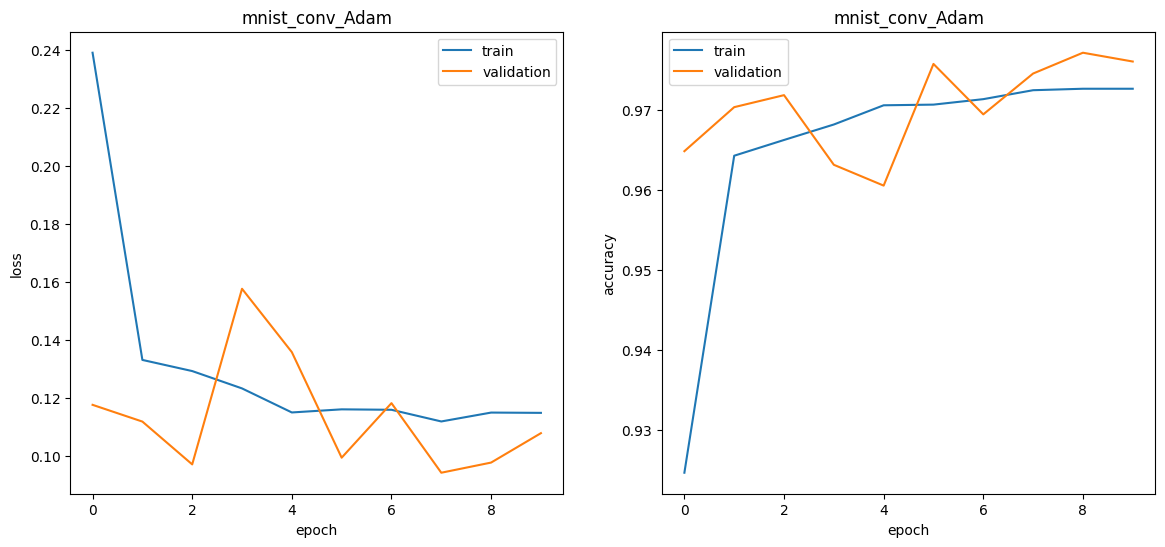

In [48]:
for name, result in history.items():

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    axs[0].plot(result['train_losses'], label='train')
    axs[0].plot(result['val_losses'], label='validation')
    axs[0].set_ylabel('loss')

    axs[1].plot(result['train_accuracies'], label='train')
    axs[1].plot(result['val_accuracies'], label='validation')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_title(name)
        ax.set_xlabel('epoch')
        ax.legend()

## **Выводы**

- **Momentum**: хороший парень, даёт более-менее стабильные результаты вне зависимости от сети. Переобучился в конце эпох в FC
- **AdaDelta**: не лучшие результаты в FC, но хорошо справилась в Conv
- **Adam**: лучшие результаты в FC, быстро сошёлся и как будто быстро переобучился. Хуже других справился в Conv. Интересно то, что его шатает больше всех

В целом свёрточные сети стартуют с меньшей ошибки и дают лучшее качество